# Data Preparation - Imputing Missing Features
---
Instead of dropping the features where banned players are missing a lot of values, I want to attempt to impute them.

In [1]:
from Utils import setup_database_connection, true, false
from Utils import load_all_players
from Utils import COLOUR_BANNED, COLOUR_NON_BANNED, COLOUR_BLUE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

engine = setup_database_connection()
player_data = load_all_players(engine)
banned_player_data = player_data[player_data['has_ban'] == true]
non_banned_player_data = player_data[player_data['has_ban'] == false]

Connecting to database...
Connection successful!
Loaded 260829 players


This is a repeat of the mean distributions for each feature from before, this is what we will be comparing against when we impute missing values. We don't want to use the below features.

In [2]:
features_to_exclude = ['he_friends_damage_avg', 'rating_opening', 'rating_ct_leetify', 'rating_t_leetify', 't_opening_aggression_success_rate', 'rating_clutch', 'steam_id', 'created_at', 'updated_at', 'rank_premier', 'rank_faceit_elo', 'total_matches']

In [3]:
numeric_cols = player_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in features_to_exclude]

banned_means = banned_player_data[numeric_cols].mean()
non_banned_means = non_banned_player_data[numeric_cols].mean()

difference = banned_means - non_banned_means

comparison_df = pd.DataFrame({
    'Feature': numeric_cols,
    'Non-Banned Mean': non_banned_means.values,
    'Banned Mean': banned_means.values,
})


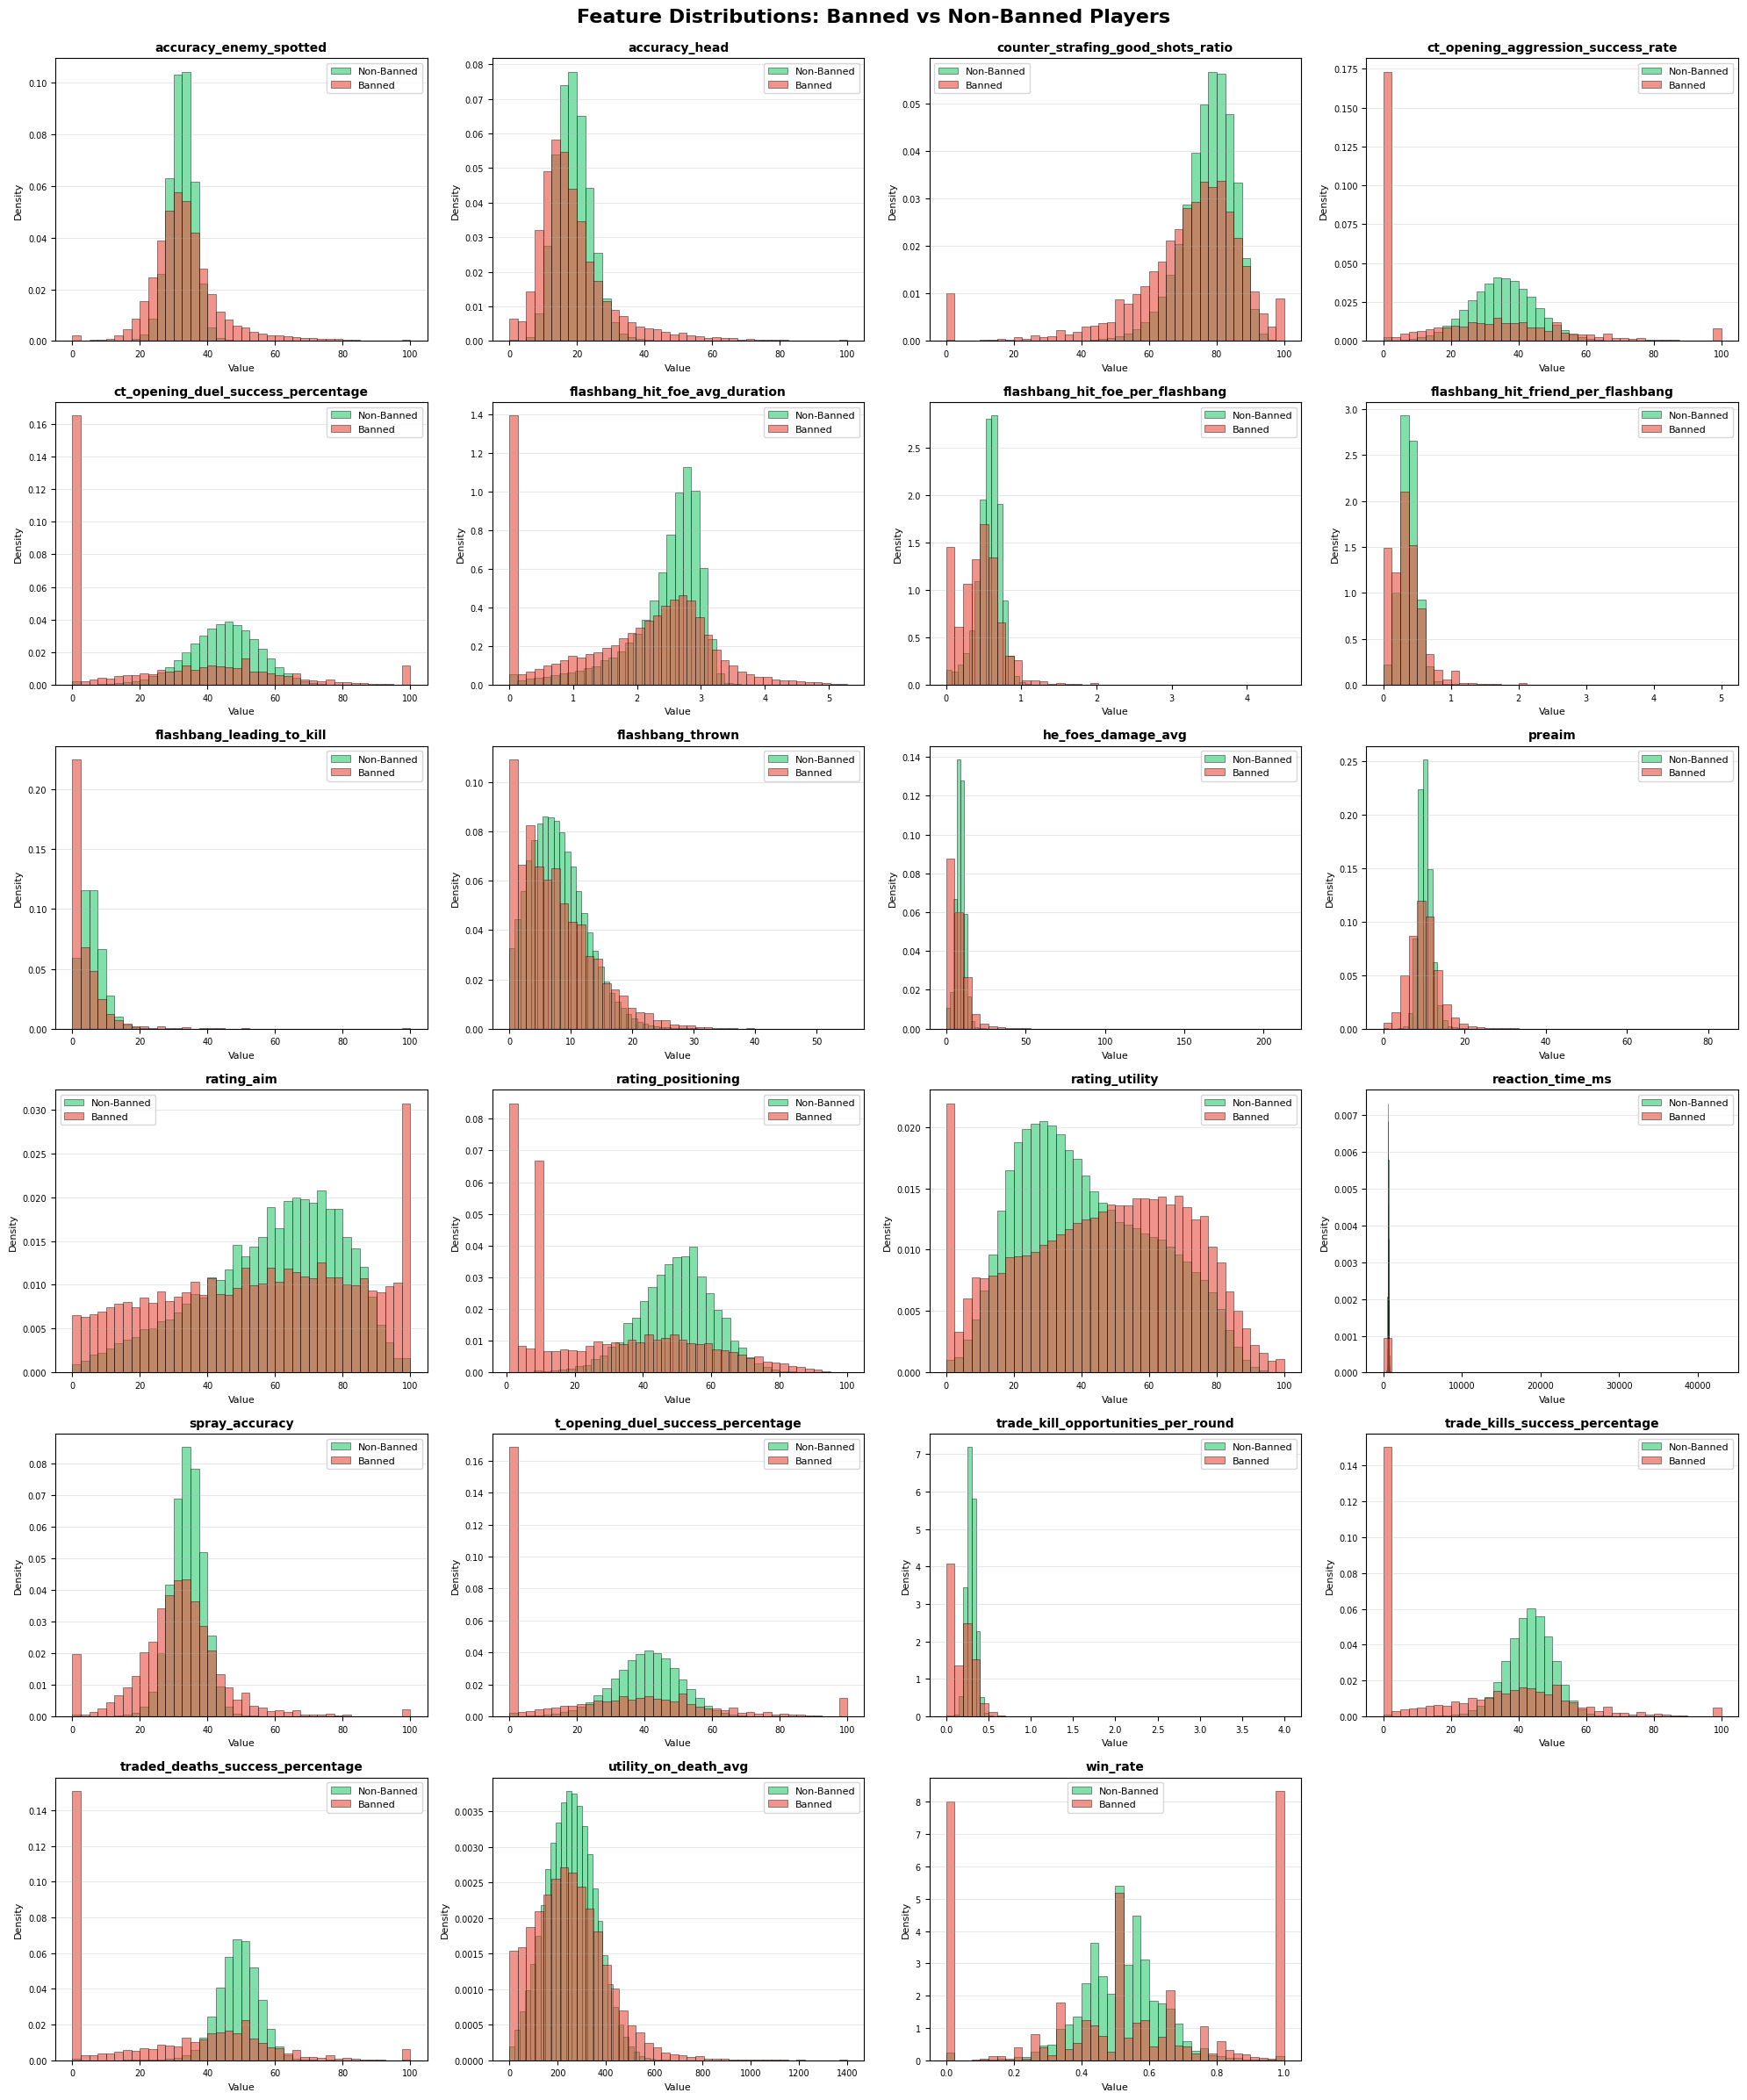

In [4]:
features = comparison_df['Feature'].tolist()

n_features = len(features)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    
    non_banned_data = non_banned_player_data[feature].dropna()
    banned_data = banned_player_data[feature].dropna()
    
    ax.hist(non_banned_data, bins=40, alpha=0.6, color=COLOUR_NON_BANNED,
            label='Non-Banned', density=True, edgecolor='black', linewidth=0.5)
    ax.hist(banned_data, bins=40, alpha=0.6, color=COLOUR_BANNED,
            label='Banned', density=True, edgecolor='black', linewidth=0.5)

    ax.set_title(feature, fontsize=10, weight='bold')
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='both', labelsize=7)
    ax.legend(fontsize=8)

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions: Banned vs Non-Banned Players', 
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

Now im going to impute missing values for both banned and non banned players missing values (separately then recombine). Hopefully then the mean distributions will make more sense and not be severely skewed by missing data.

In [5]:
from sklearn.impute import KNNImputer

banned_data = banned_player_data.copy()
non_banned_data = non_banned_player_data.copy()

for col in numeric_cols:
    banned_data.loc[banned_data[col] == 0, col] = np.nan
    non_banned_data.loc[non_banned_data[col] == 0, col] = np.nan

print("\nMissing value percentages in banned players:")
banned_missing = (banned_data[numeric_cols].isna().sum() / len(banned_data) * 100).sort_values(ascending=False)
print(banned_missing.head(10))

print("\nMissing value percentages in non-banned players:")
non_banned_missing = (non_banned_data[numeric_cols].isna().sum() / len(non_banned_data) * 100).sort_values(ascending=False)
print(non_banned_missing.head(10))


Missing value percentages in banned players:
flashbang_leading_to_kill             47.033226
ct_opening_aggression_success_rate    42.967227
t_opening_duel_success_percentage     41.935996
ct_opening_duel_success_percentage    41.072481
traded_deaths_success_percentage      37.398577
trade_kills_success_percentage        37.230860
trade_kill_opportunities_per_round    34.159830
he_foes_damage_avg                    22.351661
win_rate                              20.003626
flashbang_hit_foe_avg_duration        18.043153
dtype: float64

Missing value percentages in non-banned players:
flashbang_leading_to_kill             4.149843
he_foes_damage_avg                    0.820001
flashbang_hit_friend_per_flashbang    0.700485
flashbang_hit_foe_per_flashbang       0.687103
ct_opening_aggression_success_rate    0.620654
win_rate                              0.565279
t_opening_duel_success_percentage     0.562049
flashbang_hit_foe_avg_duration        0.506675
ct_opening_duel_success_percentag

In [6]:
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

banned_imputed_values = knn_imputer.fit_transform(banned_data[numeric_cols])
banned_imputed = banned_data.copy()
banned_imputed[numeric_cols] = banned_imputed_values

non_banned_imputed_values = knn_imputer.fit_transform(non_banned_data[numeric_cols])
non_banned_imputed = non_banned_data.copy()
non_banned_imputed[numeric_cols] = non_banned_imputed_values

imputed_player_data = pd.concat([banned_imputed, non_banned_imputed], ignore_index=True)

In [7]:
banned_means_before = banned_player_data[numeric_cols].mean()
non_banned_means_before = non_banned_player_data[numeric_cols].mean()

banned_means_after = banned_imputed[numeric_cols].mean()
non_banned_means_after = non_banned_imputed[numeric_cols].mean()

pct_diff_before = ((banned_means_before - non_banned_means_before) / non_banned_means_before * 100).fillna(0)
pct_diff_after = ((banned_means_after - non_banned_means_after) / non_banned_means_after * 100).fillna(0)

comparison = pd.DataFrame({
    'Feature': numeric_cols,
    'Before - Banned': banned_means_before.values,
    'Before - Non-Banned': non_banned_means_before.values,
    'Before - Diff %': pct_diff_before.values,
    'After - Banned': banned_means_after.values,
    'After - Non-Banned': non_banned_means_after.values,
    'After - Diff %': pct_diff_after.values
})

comparison['Abs Diff After'] = comparison['After - Diff %'].abs()
comparison = comparison.sort_values('Abs Diff After', ascending=False)

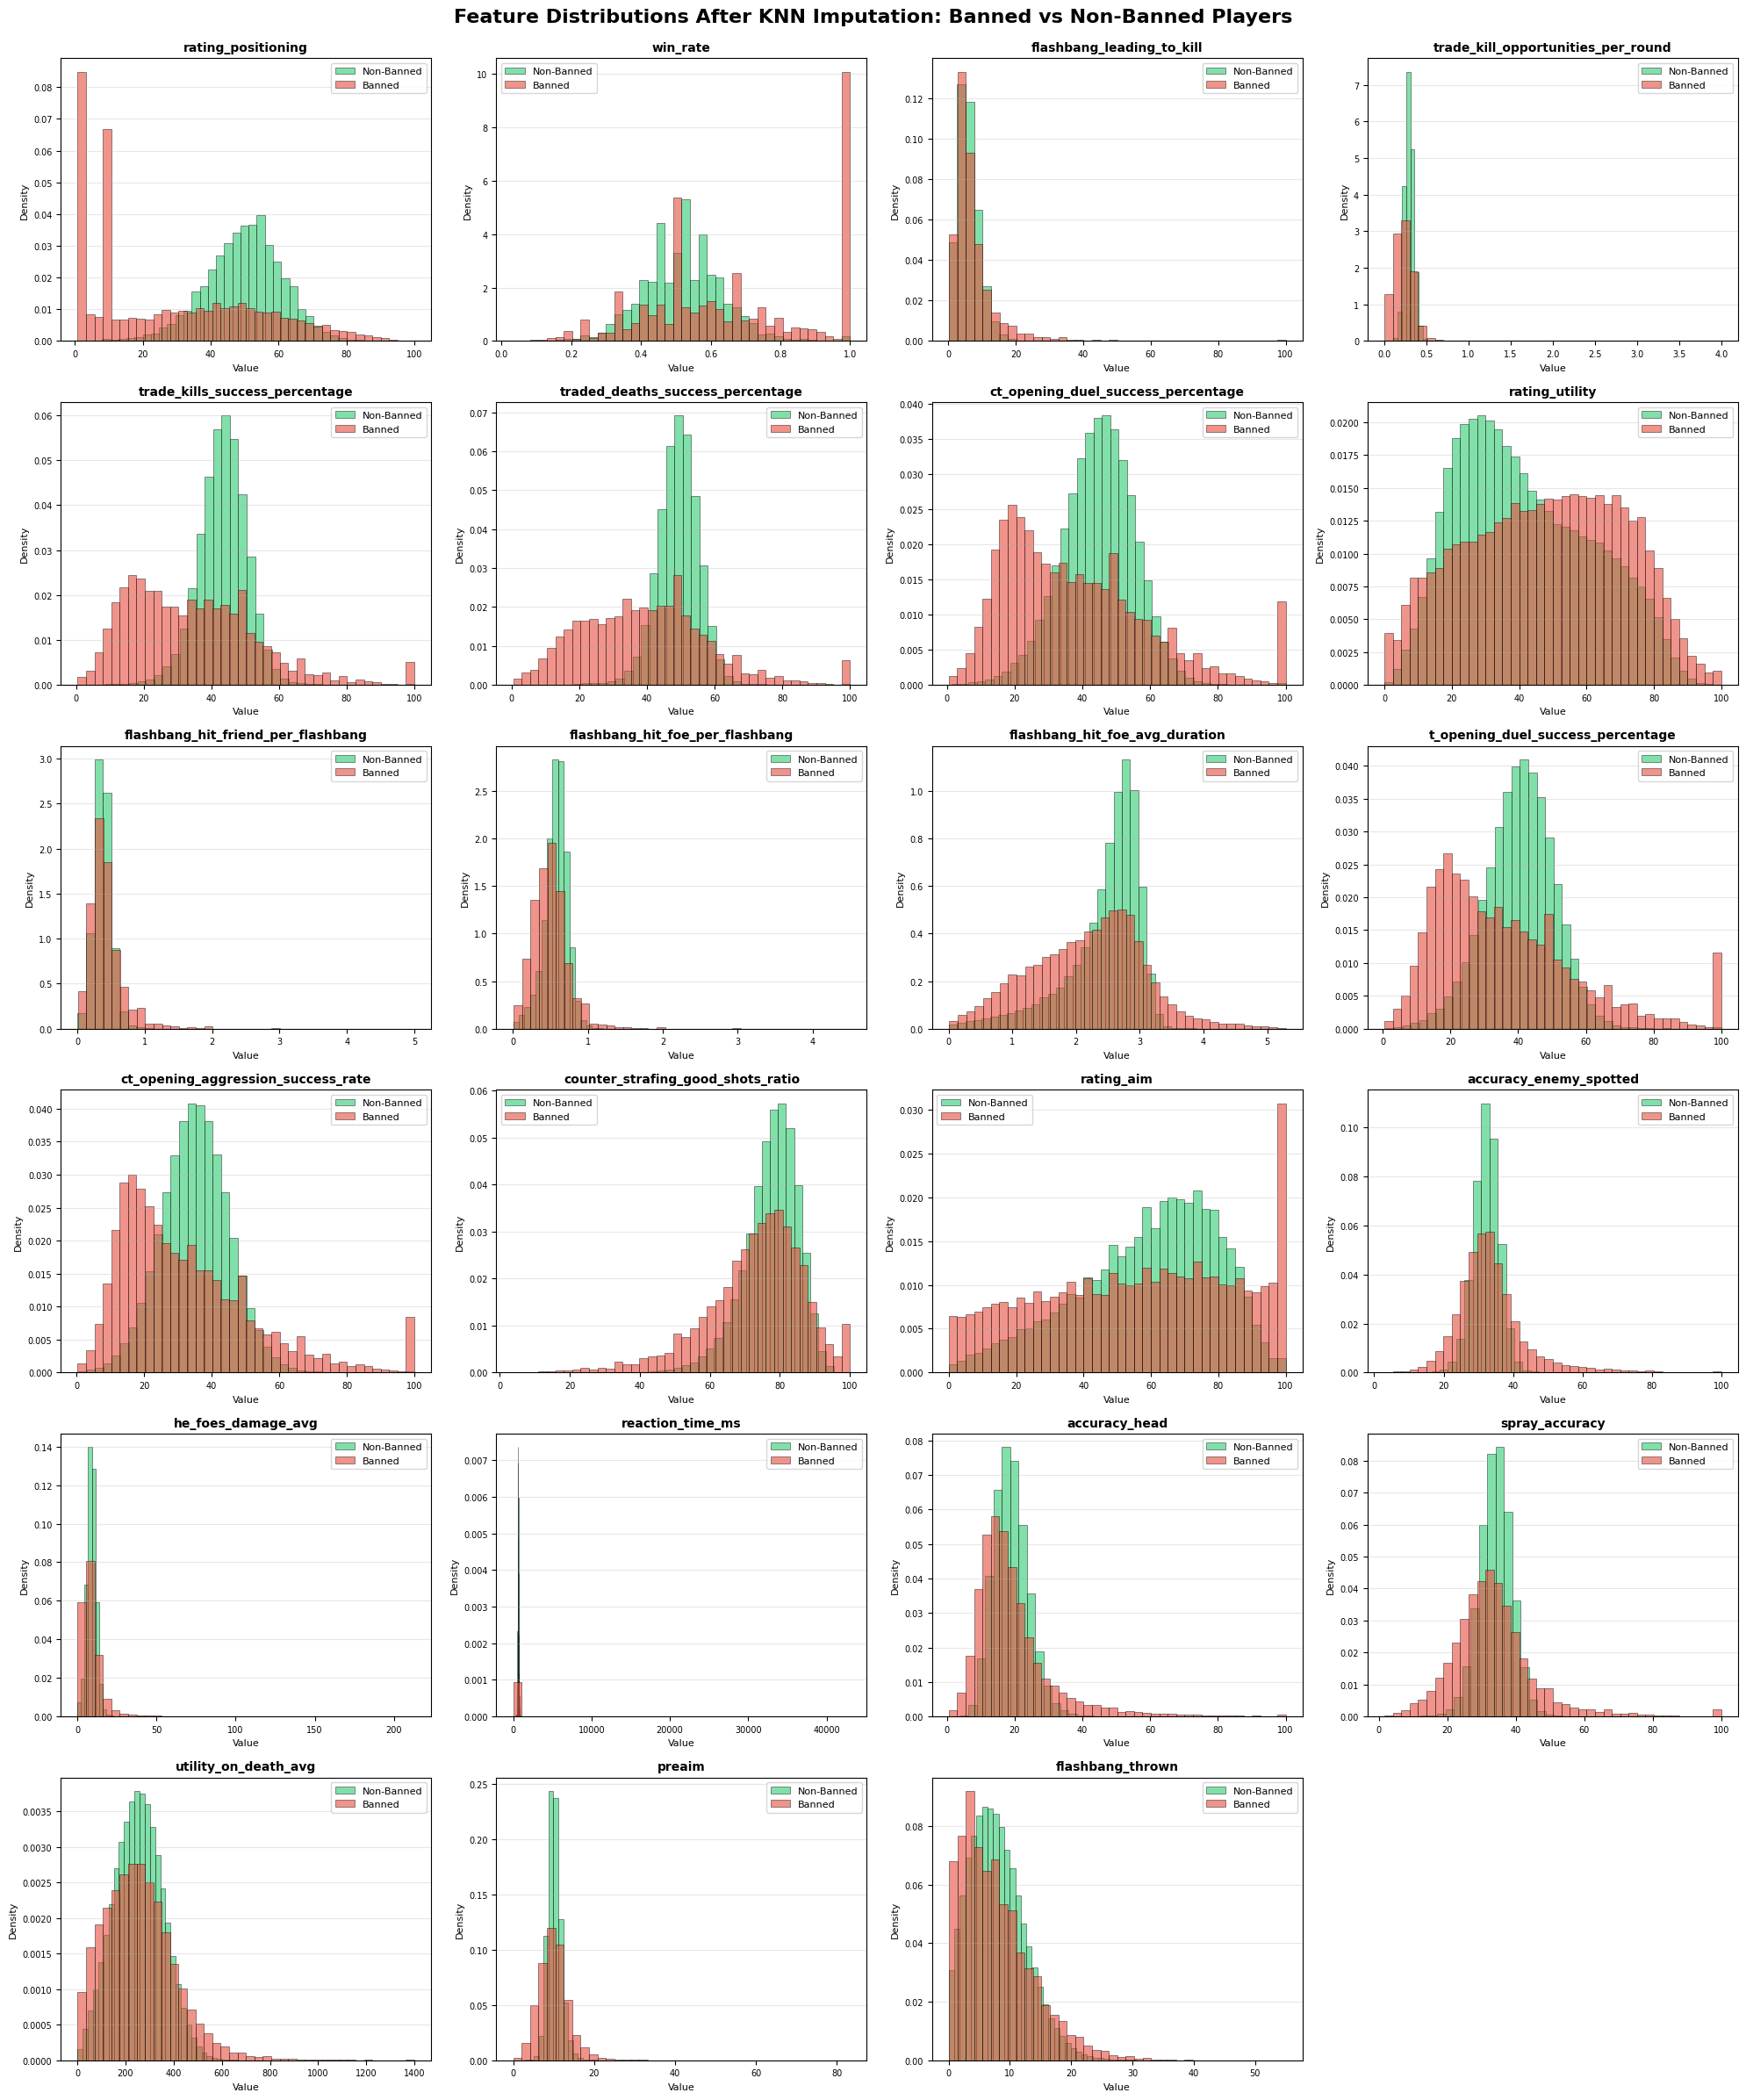

In [8]:
features = comparison['Feature'].tolist()

n_features = len(features)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    
    non_banned_data = non_banned_imputed[feature].dropna()
    banned_data = banned_imputed[feature].dropna()
    
    ax.hist(non_banned_data, bins=40, alpha=0.6, color=COLOUR_NON_BANNED,
            label='Non-Banned', density=True, edgecolor='black', linewidth=0.5)
    ax.hist(banned_data, bins=40, alpha=0.6, color=COLOUR_BANNED,
            label='Banned', density=True, edgecolor='black', linewidth=0.5)

    ax.set_title(feature, fontsize=10, weight='bold')
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='both', labelsize=7)
    ax.legend(fontsize=8)

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions After KNN Imputation: Banned vs Non-Banned Players', 
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

Now I will do a side by side distribution for each feature to show the difference before and after imputation.

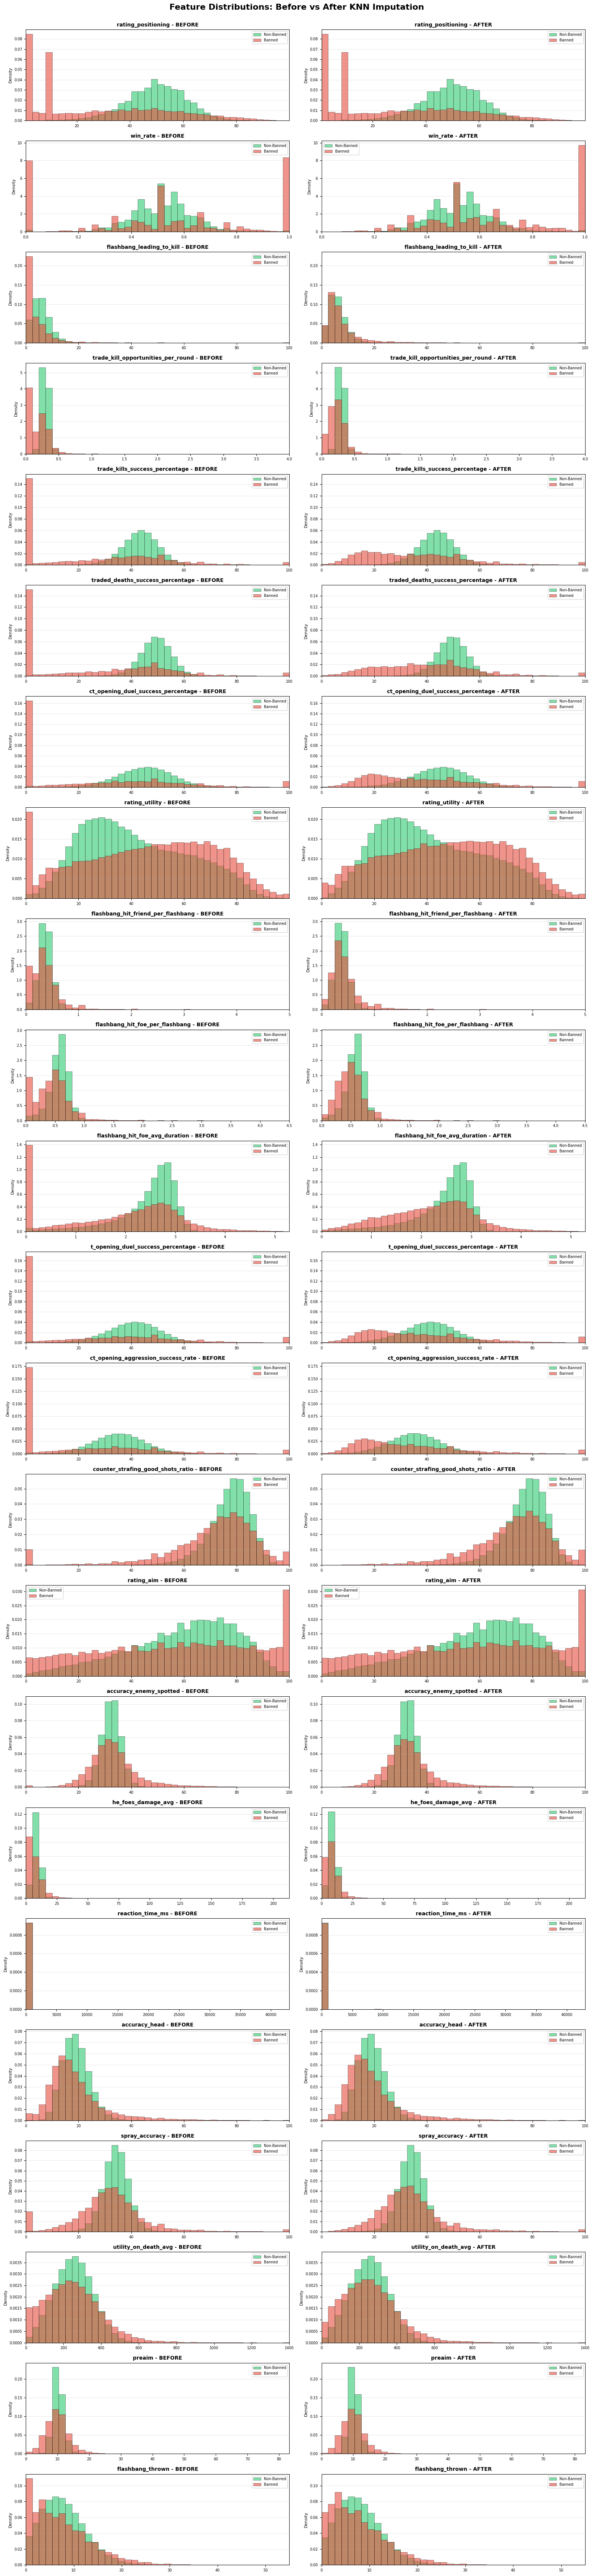

In [9]:
# Side-by-side before/after comparison for ALL features
features = comparison['Feature'].tolist()

n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(16, n_features * 3))

for idx, feature in enumerate(features):
    # Get data for both before and after
    before_non_banned = non_banned_player_data[feature].dropna()
    before_banned = banned_player_data[feature].dropna()
    after_non_banned = non_banned_imputed[feature].dropna()
    after_banned = banned_imputed[feature].dropna()
    
    # Calculate shared x-axis limits
    all_values = pd.concat([before_non_banned, before_banned, after_non_banned, after_banned])
    x_min, x_max = all_values.min(), all_values.max()
    
    # Before imputation (left column)
    ax_before = axes[idx, 0]
    ax_before.hist(before_non_banned, 
                   bins=40, alpha=0.6, color=COLOUR_NON_BANNED,
                   label='Non-Banned', density=True, edgecolor='black', linewidth=0.5,
                   range=(x_min, x_max))
    ax_before.hist(before_banned, 
                   bins=40, alpha=0.6, color=COLOUR_BANNED,
                   label='Banned', density=True, edgecolor='black', linewidth=0.5,
                   range=(x_min, x_max))
    ax_before.set_title(f'{feature} - BEFORE', fontsize=10, weight='bold')
    ax_before.set_ylabel('Density', fontsize=8)
    ax_before.set_xlim(x_min, x_max)
    ax_before.grid(axis='y', alpha=0.3)
    ax_before.legend(fontsize=7)
    ax_before.tick_params(axis='both', labelsize=7)
    
    # After imputation (right column)
    ax_after = axes[idx, 1]
    ax_after.hist(after_non_banned, 
                  bins=40, alpha=0.6, color=COLOUR_NON_BANNED,
                  label='Non-Banned', density=True, edgecolor='black', linewidth=0.5,
                  range=(x_min, x_max))
    ax_after.hist(after_banned, 
                  bins=40, alpha=0.6, color=COLOUR_BANNED,
                  label='Banned', density=True, edgecolor='black', linewidth=0.5,
                  range=(x_min, x_max))
    ax_after.set_title(f'{feature} - AFTER', fontsize=10, weight='bold')
    ax_after.set_ylabel('Density', fontsize=8)
    ax_after.set_xlim(x_min, x_max)
    ax_after.grid(axis='y', alpha=0.3)
    ax_after.legend(fontsize=7)
    ax_after.tick_params(axis='both', labelsize=7)
    
    # Match y-axis limits for easier comparison
    y_max = max(ax_before.get_ylim()[1], ax_after.get_ylim()[1])
    ax_before.set_ylim(0, y_max)
    ax_after.set_ylim(0, y_max)

plt.suptitle('Feature Distributions: Before vs After KNN Imputation', 
             fontsize=16, weight='bold', y=1.0)
plt.tight_layout()
plt.show()

# Conclusion
---
The distributions are definetely looking better but visually I would say not much better. Nevertheless we have an expanded feature set to work with so that might also make a big difference so I will train the model using this technique and see how it goes.